In [1]:
import gymnasium as gym
import os
import numpy as np
import sys
sys.path.append(os.path.join("C:\\Users", "Manan", "OneDrive", "Documents", "orbit_project"))

import orbit_optimization_project
from orbit_optimization_project.orbit_env.orbit_env import OrbitEnv

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
#from stable_baselines3.common.buffer import RolloutBufferWithSampling
from torch.nn import LeakyReLU

from gymnasium.envs.registration import register

register(
    id='OrbitEnv-v0',
    entry_point='orbit_optimization_project.orbit_env:OrbitEnv',
    max_episode_steps=300
)

print("OrbitEnv-v0 registered successfully!")

C:\Users\Manan\OneDrive\Documents\orbit_project\orbit_optimization_project\orbit_env\orbit_env.py:20: SyntaxWarning: invalid escape sequence '\ '
  """


OrbitEnv-v0 registered successfully!


C:\Users\Manan\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:644: UserWarning: WARN: Overriding environment OrbitEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


# Change working directory

In [3]:
import os

In [7]:
os.chdir(r"C:\Users\Manan\OneDrive\Documents\orbit_project\orbit_optimization_project")

In [5]:
os.getcwd()

'C:\\Users\\Manan'

# Creating Environment

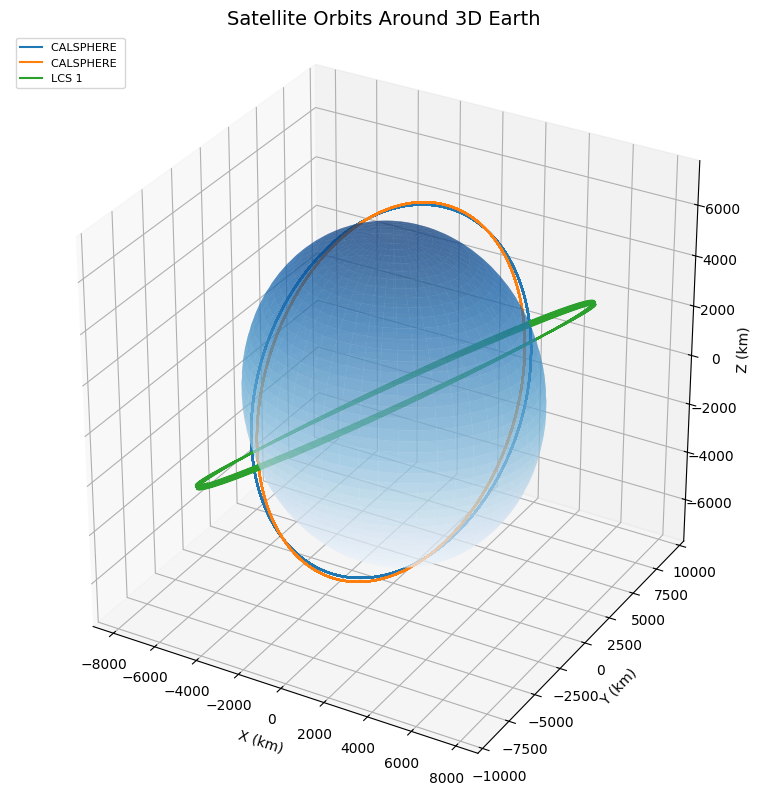

Plotted 7380 satellites within altitude range (700.0, 1550.0)



In [9]:
raw_env = gym.make("OrbitEnv-v0")

In [11]:
raw_env.action_space.sample()

array([7.8068140e+03, 1.0108608e-02, 2.5619102e+00, 4.8798528e+00,
       4.9593744e-01], dtype=float32)

# Creating vector environment 

In [14]:
vec_env_raw = DummyVecEnv([lambda: raw_env])

# Normalize the vector environment -> Normalized obs and rewards

In [17]:
vec_env = VecNormalize( # Must be saved when model is saved
    vec_env_raw,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    norm_obs_keys = ["orbital_elements"]
) 

In [19]:
vec_env.action_space.sample()

array([7.8341650e+03, 8.4662832e-02, 2.8126936e+00, 5.1862817e+00,
       1.3772159e+00], dtype=float32)

# Creating logs and evaluation env

Logging to ./logs/


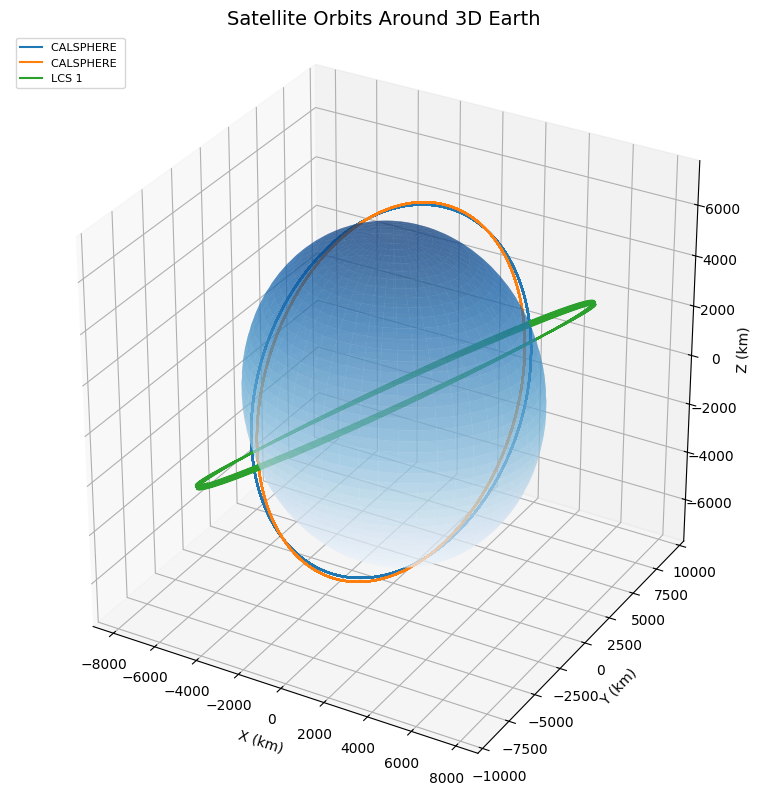

Plotted 7380 satellites within altitude range (700.0, 1550.0)



C:\Users\Manan\anaconda3\Lib\site-packages\gymnasium\utils\passive_env_checker.py:174: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed=42
  logger.warn(


In [22]:
log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)

# Configuring logger to output logs to console and files
new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"]) 

# Base evaluation env
eval_env_raw = gym.make('OrbitEnv-v0')
# seeding the environment
eval_env_raw.reset(seed=42)

eval_vec_env = DummyVecEnv([lambda:eval_env_raw])
eval_env = VecNormalize(
    eval_vec_env, 
    training=False, 
    norm_obs=True, 
    norm_reward=False,
    clip_obs=10.0,
    norm_obs_keys = ["orbital_elements"]
) 

In [24]:
eval_env.action_space.sample()

array([7.1419990e+03, 2.6678856e-02, 2.6086702e+00, 5.4103765e+00,
       3.8265266e+00], dtype=float32)

# Custom callbacks

In [27]:
class RewardPlateauEscapeCallback(BaseCallback):
    def __init__(self, eval_env, threshold=0.01, patience=3, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.threshold = threshold
        self.patience = patience
        self.recent_rewards = []
    
    def _on_rollout_end(self):
        """Called at the end of each rollout"""
        mean_reward = self.evaluate_agent()
        self.recent_rewards.append(mean_reward)
        
        # Keep only the last 'patience' number of rewards
        if len(self.recent_rewards) > self.patience:
            self.recent_rewards.pop(0)
        
        # Check for plateau only when we have enough data points
        if len(self.recent_rewards) == self.patience:
            reward_changes = np.diff(self.recent_rewards)
            if np.all(np.abs(reward_changes) < self.threshold):
                if self.verbose:
                    print(f"\n[Plateau Detected] Forcing Exploration Jump at step {self.num_timesteps}")
                    print(f"Recent rewards: {self.recent_rewards}")
                    print(f"Reward changes: {reward_changes}")
                self.force_exploration()
    
    def evaluate_agent(self, n_eval_episodes=3):
        """Evaluate the current agent performance"""
        total_rewards = []
        for _ in range(n_eval_episodes):
            obs = self.eval_env.reset()
    
            if isinstance(obs, (list, tuple)) and len(obs) == 1:
                obs = obs[0]

    
            done = False
            ep_reward = 0.0
    
            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                step_result = self.eval_env.step(action)
    
                # Handle old (4) and new (5) Gym step API
                if len(step_result) == 5:
                    obs, reward, terminated, truncated, info = step_result
                    done = terminated or truncated
                else:
                    obs, reward, done, info = step_result
    
                # If reward is in array format (for VecEnv), extract scalar
                if isinstance(reward, (list, np.ndarray)):
                    reward = reward[0]
    
                ep_reward += reward
    
            total_rewards.append(ep_reward)
    
        return np.mean(total_rewards)

    
    def force_exploration(self):
        """Force environment to reset and escape local optimum."""
        # Access the training environment
        training_env = self.training_env
        
        # Handle VecNormalize wrapper
        if hasattr(training_env, 'venv'):
            # training_env is VecNormalize, access underlying vectorized env
            underlying_env = training_env.venv
            if hasattr(underlying_env, 'envs') and len(underlying_env.envs) > 0:
                # Multiple environments in vector
                for i, env in enumerate(underlying_env.envs):
                    if hasattr(env, "reset"):
                        env.reset()
                        if self.verbose:
                            print(f"[Exploration Jump] Env {i} triggered.")
                    else:
                        if self.verbose:
                            print(f"[Warning] Env {i} does not support reset().")
            elif hasattr(underlying_env, 'envs') and len(underlying_env.envs) == 1:
                # Single environment in DummyVecEnv
                env = underlying_env.envs[0]
                if hasattr(env, "reset"):
                    env.reset()
                    if self.verbose:
                        print("[Exploration Jump] Environment reset triggered.")
                else:
                    if self.verbose:
                        print("[Warning] Environment is not able to access reset().")
            else:
                if self.verbose:
                    print("[Warning] Could not access environment through VecNormalize wrapper.")
        elif hasattr(training_env, "envs") and len(training_env.envs) > 0:
            # Direct vectorized environment without VecNormalize
            for i, env in enumerate(training_env.envs):
                if hasattr(env, "reset"):
                    env.reset()
                    if self.verbose:
                        print(f"[Exploration Jump] Env {i} reset triggered.")
                else:
                    if self.verbose:
                        print(f"[Warning] Env {i} does not support reset().")
        else:
            # Fallback: try direct access
            if hasattr(training_env, "reset"):
                training_env.reset()
                if self.verbose:
                    print("[Exploration Jump] Environment reset triggered.")
            else:
                if self.verbose:
                    print("[Warning] Environment does not support reset().")
    
    def _on_step(self):
        """Called after each step (required by BaseCallback)"""
        return True  # Continue training

# Callbacks

In [30]:
# Evaluation Callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=os.path.join(log_dir, "Orbit_model_v0"),
    log_path=log_dir,
    eval_freq=1000,
    n_eval_episodes=5,  
    deterministic=True,
    render=False,
)

In [32]:
# Custom relocation callback
relocation_callback = RewardPlateauEscapeCallback(
    eval_env,
    threshold =0.25, # Minimum change in reward to be considered as 'Improvement'
    patience = 3,  # Number of episodes to be checked 
    verbose = 1
)

# Check for any warnings before starting training

In [35]:
from stable_baselines3.common.env_checker import check_env
check_env(raw_env, warn=True)

C:\Users\Manan\anaconda3\Lib\site-packages\stable_baselines3\common\env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [37]:
from stable_baselines3.common.env_checker import check_env
check_env(eval_env_raw, warn=True)

# Define the Model policy, algorithm and other parameters

In [42]:
model = PPO(
    "MultiInputPolicy",
    vec_env,
    learning_rate = 0.0001,
    n_epochs = 8,
    gamma = 0.99,
    gae_lambda = 0.98,
    normalize_advantage = True,
    ent_coef = 0.03,
    vf_coef = 0.75,
    max_grad_norm = 0.6,
    use_sde = True,
    sde_sample_freq = 75,
    #rollout_buffer_class = RolloutBuffer,
    #rollout_buffer_kwargs = {
    #    'gamma' : 0.98,
    #    'gae_lambda' : 0.95,
    #    'optimize_memory_usage' : True
    #},
    # Rollout buffer is not used as RolloutBuffer/ RolloutBufferWithSampling is not yet public AP compatible for this version of SB3
    target_kl = 0.3,
    stats_window_size = 100,
    tensorboard_log=log_dir,
    policy_kwargs = {
        'activation_fn' : LeakyReLU,
        'net_arch' : {
                'pi': [512, 256, 128],
                'vf': [512, 256, 128]
            },
        'ortho_init' : True,
        'squash_output' : True
    },
    verbose=1,
    seed = 42,
)

model.set_logger(new_logger)


Using cuda device


# Start Training

In [45]:
model.learn(
    total_timesteps=60000, 
    callback=[relocation_callback, eval_callback]
)

C:\Users\Manan\anaconda3\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=1.72 +/- 0.00
Episode length: 1.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1        |
|    mean_reward     | 1.72     |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=1.72 +/- 0.00
Episode length: 1.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1        |
|    mean_reward     | 1.72     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 1    |
|    iterations      | 1    |
|    time_elapsed    | 1109 |
|    total_timesteps | 2048 |
-----------------------------
Early stopping at step 2 due to reaching max kl: 0.46
Eval num_timesteps=3000, episode_reward=1.72 +/-

# Testing model prediction

In [47]:
obs = vec_env.reset()
action, _ = model.predict(obs, deterministic=True)

obs, reward, terminated, info = vec_env.step(action)

print("Orbit parameters:", action[0])
print("Reward:", reward[0])
print("Objectives met:", info[0]['all_objectives_met'])

Orbit parameters: [7.0781372e+03 1.0000000e-01 3.1415915e+00 1.1398683e-02 6.2831011e+00]
Reward: 9.263025
Objectives met: True


# Additional training


In [ ]:
model.learn(total_timesteps=5000, reset_num_timesteps = False, callback=eval_callback)

# To check tensorboard logs

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

# To save the model and vec_env

In [56]:
model.save("ppo_orbit_prediction_RL_model(61440_time_steps)")
vec_env.save("orbit_vec_normalize.pkl")

# To reload the model

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
import gymnasium as gym

# Recreate env and wrap
raw_env = DummyVecEnv([lambda: gym.make('OrbitEnv-v0')])
vec_env = VecNormalize.load("./logs/orbit_vec_normalize.pkl", raw_env)
vec_env.training = False
vec_env.norm_reward = False

# Load model
model = PPO.load("./logs/ppo_orbit_prediction_RL_model", env=vec_env)
